# MSc Course Mai-June 2022

This part of the course will guid you through the analysis of 2 Photon Calcium Imaging data.
Before, you recorded the response of a specific neuron type (Tm9-lexA>>lexAop-GCaMP6f) while the fly was shown sine wave gratings of 5 different luminances. Now we want to analyse this data and show you the following necessary steps to do this:

1. Movement correction
2. Pre-analysis (Folder structure)
3. Region of Intrest (ROI) selection
4. Background subtraction
5. df/f calculation and trial average
6. SNR (Signal to Noise Ratio) and Reliability calculation
7. Analysis dependend on stimulus type
8. Save analysed data
9. Ploting the data

### 1. Movement correction

Movement correction is important to get rid of small movements of the brain and stabilize the recording. In the same process the single TIFF files from the microscope are registered into one TIFF stack, which is than used for further analysis.

We will use an ImageJ macro with the plugin *Image Stabilizer*, which is based on the Lucas-Kanade optical flow algorithm. This algorithm estimates geometrical transformation based on spacial intensity information of two consecutive images and predicts the best alignment between them.

To give you an example of the effect of Motion alignment please follow this link: https://www.cs.cmu.edu/~kangli/code/Image_Stabilizer.html


#### How to do it yourself:

- Open ImageJ
- Open the macro with the file **Batch_imagestabilizer_MSc_course.ijm**
- Check within the macro the data path to save the aligned TIFF stack:
    `saveAs("TIFF... ", "path_to_save"+replace(subdir,"/","")+"_Ch2_reg.tif");`
- Run the macro with Strg+R (or go to Macros -> Run Macro or just Run, depending on which version you have)
- Now select a folder of a single fly that has all the TSeries inside
- When it is finished, the aligned files are in the location you specified before and can be sorted to the corresponding TSeries. (The files need to be sorted first before the next fly can be aligned)

### 2. Pre-analysis (Folder structure)

Before we can start with the next step of the analysis, we need to make sure that our data is in the right location.
Please create the following folder structure:

- Experiment (genotype, e.g Tm9)
    - analyzed_data
        - Stimtype (e.g. LocalCircle_5secON_5sec_OFF_120deg_10sec, can be generated by the code itself)
            - ExpLine (can be generated by the code itself)
                - Pickle files (files that will be generated and saved here in Step 7)
    - rawData (folder name)
        - alignedData
            - folders with date+flyID (e.g. 2021_09_30_Tm9GC6f_fly1)
                - TSeries of that fly
                    - Motion aligned TIFF stack from Step 1
                    - corresponding stim_output file to this TSeries
    - stimulus_type (folder name)
        - .txt of the different stimulus input files


- Data_save_vars.txt (text file that lists the variabls/ the data we want to save in Step 7)


### 3. Region of Interest (ROI) selection

Now we can start with the main part of the analysis.
First we import everything we need and define the paths for helper functions and the data.
Then we define the experimental conditions and load imaging and stimulus information.

In [1]:
# Importing needed packages, modules and functions

import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import sys
import warnings
import matplotlib
import seaborn as sns
from scipy import stats
from scipy.stats import linregress, pearsonr
import scipy.stats as stats
from sklearn import preprocessing
from scipy import ndimage
import statsmodels.stats.multicomp as mc
import statsmodels.api as sm
from statsmodels.formula.api import ols


# The code_path must be change for the path where the code is in each PC
#code_path = r'\\fs02\jcornean$\Dokumente\python_seb_lumgrating_course\msc_course_2p_analysis\for_msc_course'
#code_path = r'C:\Users\ASUS\Dokumente\python_seb_lumgrating_course\2p_analysis\for_msc_course' 
code_path = r'C:\Users\jcornean\msc_course\2p_analysis\helper_functions'
sys.path.insert(0, code_path) 
os.chdir(code_path)
import ROI_mod_reduced_msc_course as ROI_mod
from core_functions_reduced_msc_course import saveWorkspace
import process_mov_core_reduced_msc_course as pmc
import post_analysis_core as pac
import post_analysis_1Hz_gratings_core_msc_course as pag

In [2]:
# Defining the data path
dataFolder = r'C:\Users\jcornean\msc_course'
save_data = True # choose True or False if you want to save the data and some preliminary plots
# Plot related
plot_roi_summ = True # choose True or False

In [3]:
#%% Parameters to adjust
plt.close('all') # closes all plots that may be still opend

# Experimental parameters
experiment = 'Tm9' # same name as the folder
current_exp_ID = '2022_05_17_Tm9_fly2'
current_t_series ='TSeries-05172022_fly2-005'
Genotype = 'Tm9-lexA_lexAop-GCamp6f'
save_folder_geno = 'Expline'
Age = '2-3'
Sex = 'f'

time_series_stack = 'TSeries-05172022_fly2-005_Ch2_reg.tif'# motion aligned tif stack from Step 1

# Analysis parameters
analysis_type = 'lumgratings' #stimulus type that was used

# Auto-setting of some other directories
initialDirectory = os.path.join(dataFolder, experiment)

alignedDataDir = os.path.join(initialDirectory,
                              'rawData\\alignedData')
stimInputDir = os.path.join(initialDirectory, 'stimulus_types')
saveOutputDir = os.path.join(initialDirectory, 'analyzed_data')
summary_save_dir = os.path.join(alignedDataDir,
                                '_summaries')
trash_folder = os.path.join(dataFolder, 'Trash')

# ROI selection/extraction parameters
extraction_type = 'manual' # 'SIMA-STICA' 'transfer' 'manual'  Seb: SIMA-STICA for extracting clusters. Tranfer for tranfering the ROI clusters from one sequence to other
transfer_type = 'minimal' # 'minimal' 'predefined'
transfer_data_name = '2022_05_17_Tm9_fly2-TSeries-05172022_fly2-005_manual.pickle'

use_avg_data_for_roi_extract = False
use_other_series_roiExtraction = False # ROI selection video
roiExtraction_tseries = 'TSeries-05172022_fly2-005'

In [4]:
# Get the stimulus and imaging information
dataDir = os.path.join(alignedDataDir, current_exp_ID, current_t_series)

(time_series, stimulus_information,imaging_information) = \
    pmc.pre_processing_movie (dataDir,stimInputDir,time_series_stack)
mean_image = time_series.mean(0)
current_movie_ID = current_exp_ID + '-' + current_t_series
if save_data:
    figure_save_dir = os.path.join(dataDir, 'Results')
else: 
    figure_save_dir = trash_folder

if not os.path.exists(figure_save_dir):
    os.mkdir(figure_save_dir)
experiment_conditions = \
    {'Genotype' : Genotype, 'Age': Age, 'Sex' : Sex,
     'FlyID' : current_exp_ID, 'MovieID': current_movie_ID}


Number of epochs = 6
Last trial of epoch 2 is discarded since the length was too short


#### Exercise:
For you to get familiar with the data we just loaded and with the data we will work with, please take a look at the following dictionaries:
- `stimulus_information`
- `imaging_information`
- `experiment_conditions`
and call some of the info in there, e.g. from `stimulus_information`: 'stimtype', 'duration', 'lum'

A dictionary is built by having a key and one or several values which can be called by this key. In the cell above we have an example of how it can be constructed (line 15 to 17 for). `experiment_conditions` is the name of the dictionary. `'Genotype', 'Age', 'Sex', 'FlyID'` and `'MovieID'` are the keys of this dictionary. The key is seperated from the value/s with a `:` .
By writing the dictionary name in a cell and just running that cell you can see the keys with their corresponding values.
By writing the dictionary name followed by square brackets and a key, e.g. `experiment_conditions['Genotype']`, the output will be all the values of this key.

In [6]:
stimulus_information['lum']

[0.3, 0.5, 0.4, 0.3, 0.2, 0.1]

In [7]:
# Organizing extraction parameters
if transfer_type == 'predefined':
    transfer_type = analysis_type
    
extraction_params = \
    pmc.organize_extraction_params(extraction_type,
                               current_t_series=current_t_series,
                               current_exp_ID=current_exp_ID,
                               alignedDataDir=alignedDataDir,
                               stimInputDir=stimInputDir,
                               use_other_series_roiExtraction = use_other_series_roiExtraction,
                               use_avg_data_for_roi_extract = use_avg_data_for_roi_extract,
                               roiExtraction_tseries=roiExtraction_tseries,
                               transfer_data_n = transfer_data_name,
                               transfer_data_store_dir = saveOutputDir,
                               transfer_type = transfer_type,
                               imaging_information=imaging_information,
                               experiment_conditions=experiment_conditions)
        
    
analysis_params = {'deltaF_method': 'mean',
                   'analysis_type': analysis_type} 

In [8]:
print (extraction_params, analysis_params)

{'type': 'manual'} {'deltaF_method': 'mean', 'analysis_type': 'lumgratings'}


The ROI selection we are using is not compatible with jupyter notebook, please run the raw_roi_extraction.py script in either Spyder or Visual Studio Code (VSC).
To install VSC follow this link and download the software: https://code.visualstudio.com/

Please get the variabls of the `extracted_rois` dictionary

In [9]:
# Load the pickle files with the extracted rois and unpack the roi variables.
extracted_roi_dir = summary_save_dir = os.path.join(alignedDataDir, 'extracted_rois')
os.chdir(extracted_roi_dir)
extracted_roi_file = f'{current_movie_ID}_{extraction_params["type"]}_extracted_rois.pickle'
extracted_rois = pickle.load(open(extracted_roi_file, 'rb'))

cat_masks = extracted_rois['cat_masks']
cat_names = extracted_rois['cat_names']
roi_masks = extracted_rois['roi_masks']
all_rois_image = extracted_rois['all_rois_image']
rois = extracted_rois['rois']
threshold_dict = extracted_rois['threshold_dict']

### 4. Background subtraction

In the step before you selected regions of interest, which are axon terminals of Tm9 neurons. In addition you selected a region which did not have any neurons or other structures in it, the background (bg). Now this background will be subtracted from the whole recording to reduce any noise signal.

In [10]:
# Get mask for background, needed for bg subtration later
for idx, cat_name in enumerate(cat_names):
    if cat_name.lower() == 'bg\r': # Seb: added '\r' for debugging mode
        bg_mask = cat_masks[idx]
        continue
    elif cat_name.lower() == 'bg': 
        bg_mask = cat_masks[idx]
        continue

In [11]:
# Generate ROI_bg instances
if rois == None:
    del rois
    rois = ROI_mod.generate_ROI_instances(roi_masks, cat_masks, cat_names,
                                          mean_image, 
                                          experiment_info = experiment_conditions, 
                                          imaging_info =imaging_information)

Please look at different elements of the rois

In [14]:
#task print some instances of the class rois e.g experiment_info, imaging_info, mask, source_image



In [15]:
#%% # BG subtraction
time_series = np.transpose(np.subtract(np.transpose(time_series),
                                       time_series[:,bg_mask].mean(axis=1)))
print('\n Background subtraction done...')


 Background subtraction done...


In [16]:
#%% # ROI trial separated responses
(wholeTraces_allTrials_ROIs, respTraces_allTrials_ROIs,
 baselineTraces_allTrials_ROIs) = \
    pmc.separate_trials_ROI_v4(time_series,rois,stimulus_information,
                               imaging_information['frame_rate'],
                               df_method = analysis_params['deltaF_method'])

Traces are stored in ROI objects.


In [17]:
#%% Append relevant information and calculate some parameters
list(map(lambda roi: roi.appendStimInfo(stimulus_information), rois))
list(map(lambda roi: roi.findMaxResponse_all_epochs(), rois))
list(map(lambda roi: roi.setSourceImage(mean_image), rois))

[None, None, None, None, None, None, None, None, None, None]

### 5. dF/F calculation and trial average

In this step the change in flourescence delta F (dF) at a time point t will be normalized to the baseline fluorescence F (or F0): **dF/F = (F(t)-F0)/F0**
By calculating dF/F, the responses of different neurons and different flies are comparable now and in addition, noise can be reduced.

During trial averaging, we combine the data aquired in one recording for different trials (when the same stimulus sequence is repeated for several times (here 5 times)) and take the average data for each epoch (stimulus occurence, e.g each different luminanc).

In [18]:
#%% df/f calculation and trial average 
(_, respTraces_SNR, baseTraces_SNR) = \
    pmc.separate_trials_ROI_v4(time_series,rois,stimulus_information,
                               imaging_information['frame_rate'],
                               df_method = analysis_params['deltaF_method'],
                               df_use=False)

No trace is stored in objects.


### 6. SNR (Signal to Noise Ratio) and Reliability calculation

These two values are used to filter out ROIs that do not respond at all or in any regards to the stimulus.

In [19]:
#%% SNR and reliability
if stimulus_information['random'] == 2:
    epoch_to_exclude = None
    baseTraces_SNR = respTraces_SNR.copy()
    # baseTraces_SNR[]
elif stimulus_information['random'] == 0:
    epoch_to_exclude = stimulus_information['baseline_epoch']
else:
    epoch_to_exclude = None

[SNR_rois, corr_rois] = pmc.calculate_SNR_Corr(baseTraces_SNR,
                                               respTraces_SNR,rois,
                                               epoch_to_exclude=None)


In [20]:
#%% Thresholding
if threshold_dict is None:
    print('No threshold used, all ROIs will be retained')
    thresholded_rois = rois
else:
    print('Thresholding ROIs')
    thresholded_rois = ROI_mod.threshold_ROIs(rois, threshold_dict)

final_rois = thresholded_rois
final_roi_image = ROI_mod.get_masks_image(final_rois)

No threshold used, all ROIs will be retained


ROI images saved


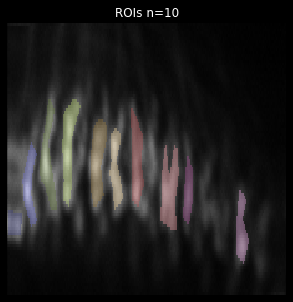

In [21]:
#%% Plotting ROIs and properties
pmc.plot_roi_masks(final_roi_image,mean_image,len(final_rois),
                   current_movie_ID,save_fig=True,
                   save_dir=figure_save_dir,alpha=0.4)

### 7. Analysis by stimulus type

C:\Users\jcornean\msc_course\2p_analysis\helper_functions\ROI_mod_reduced_msc_course.py:658: RuntimeWarning: invalid value encountered in true_divide
  epoch_TF= epoch_velocity/epoch_sWavelength
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No han

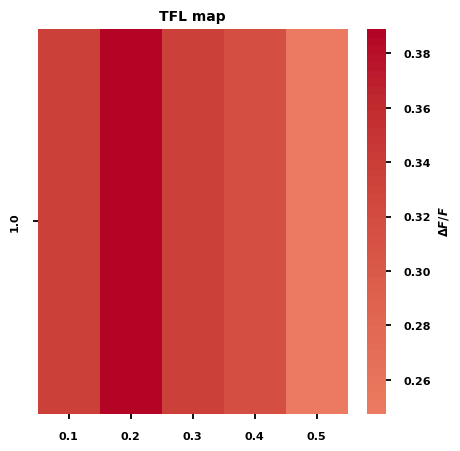

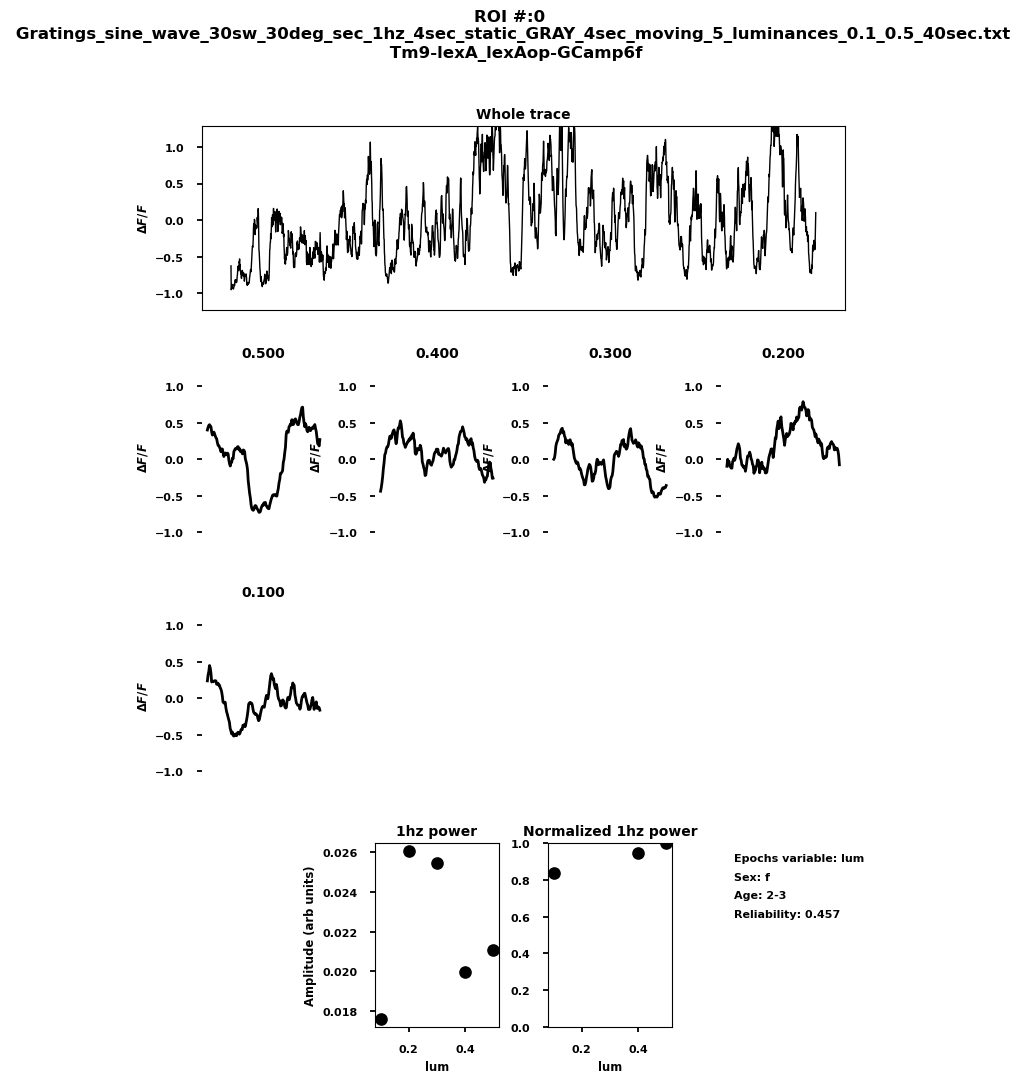

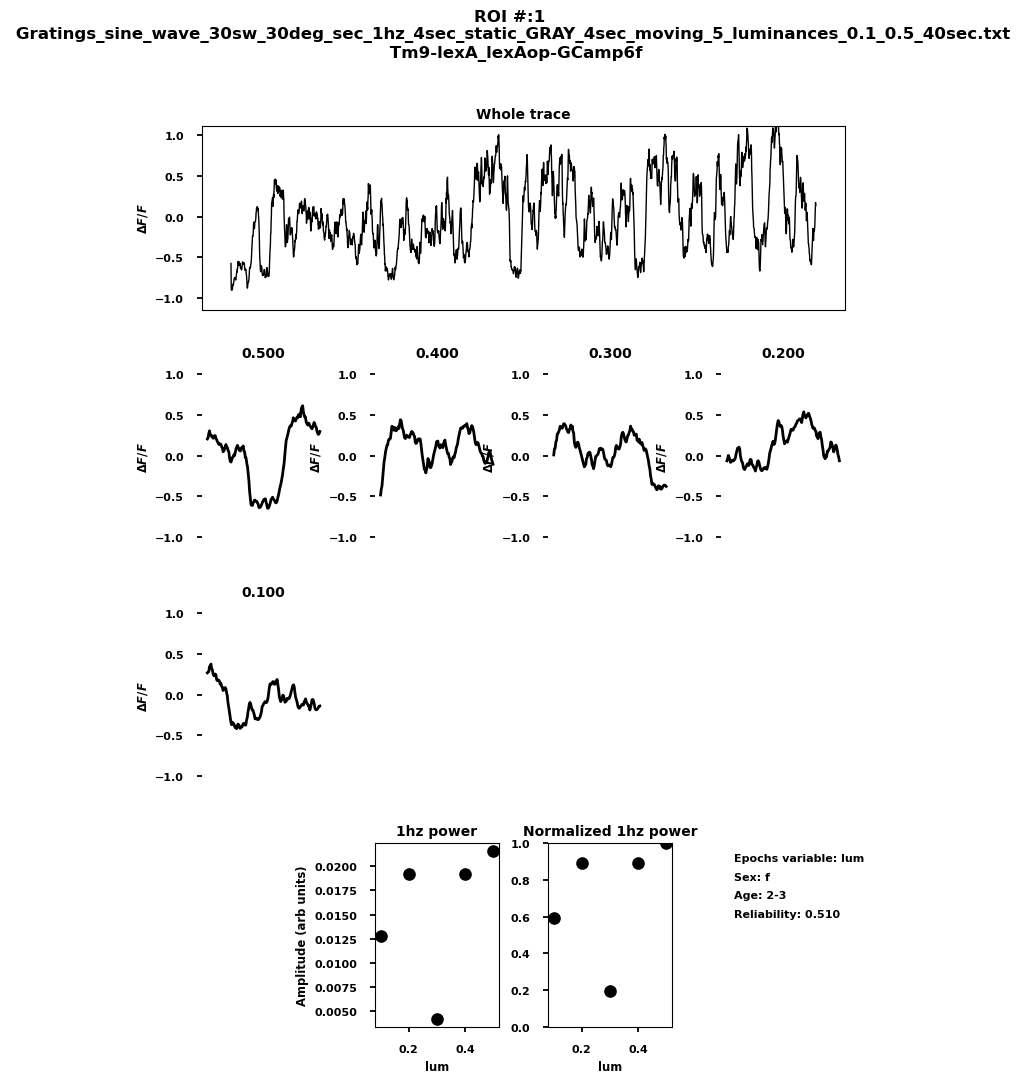

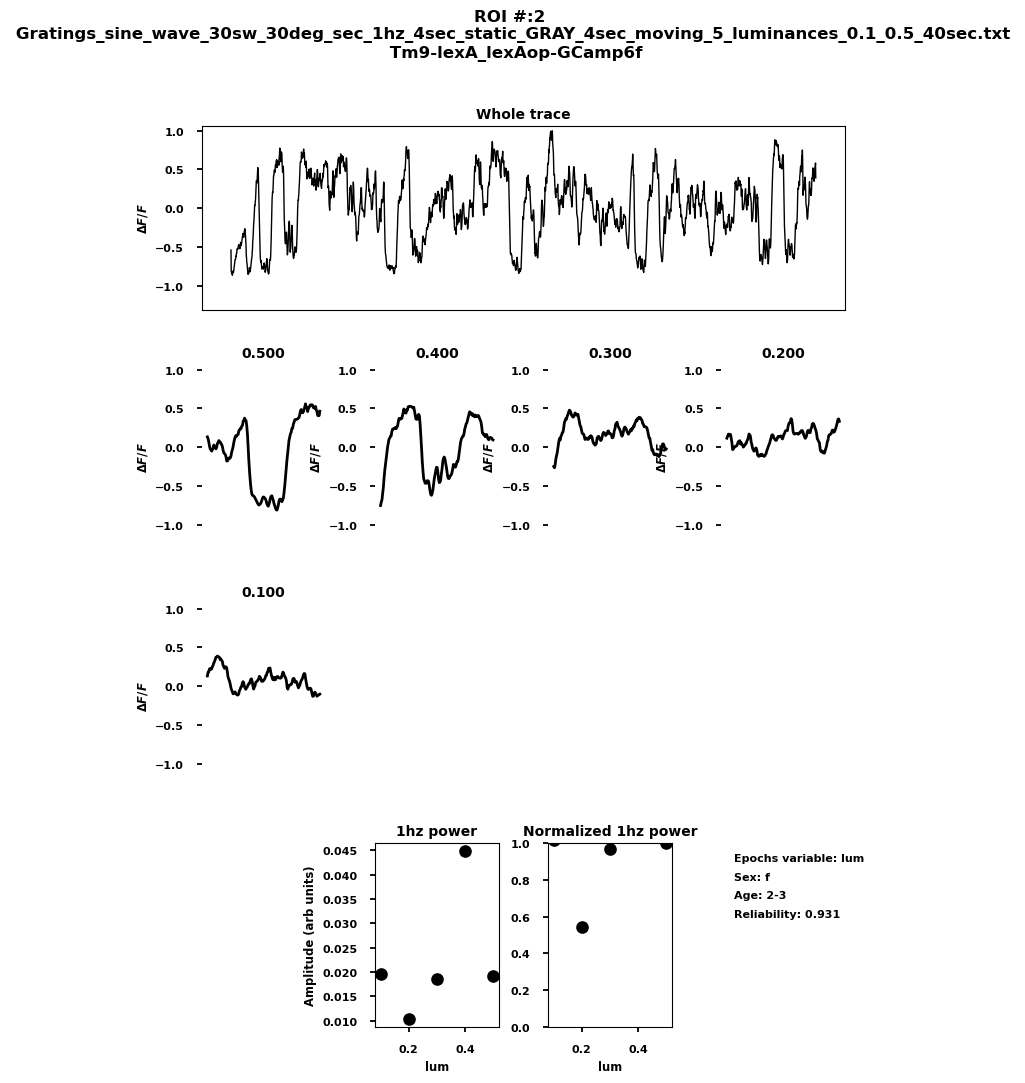

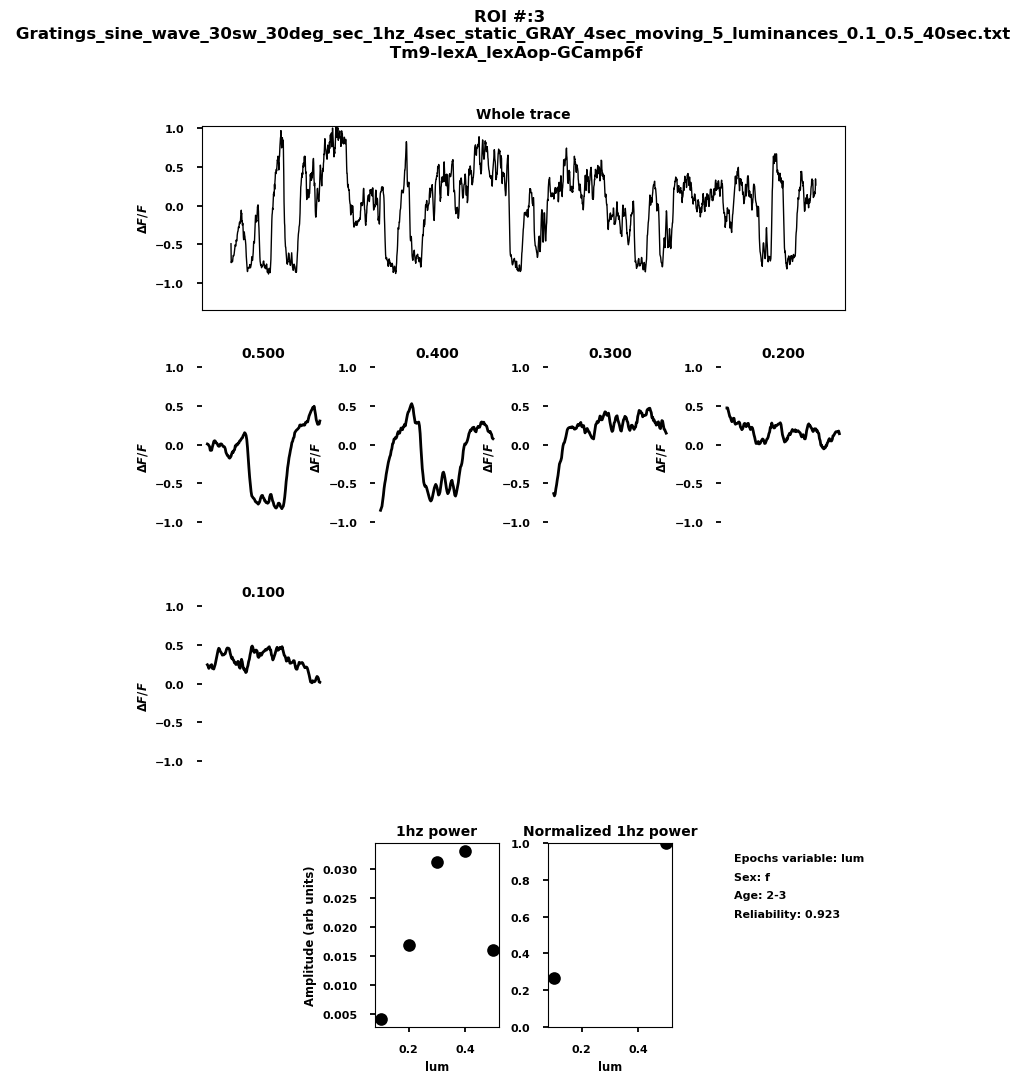

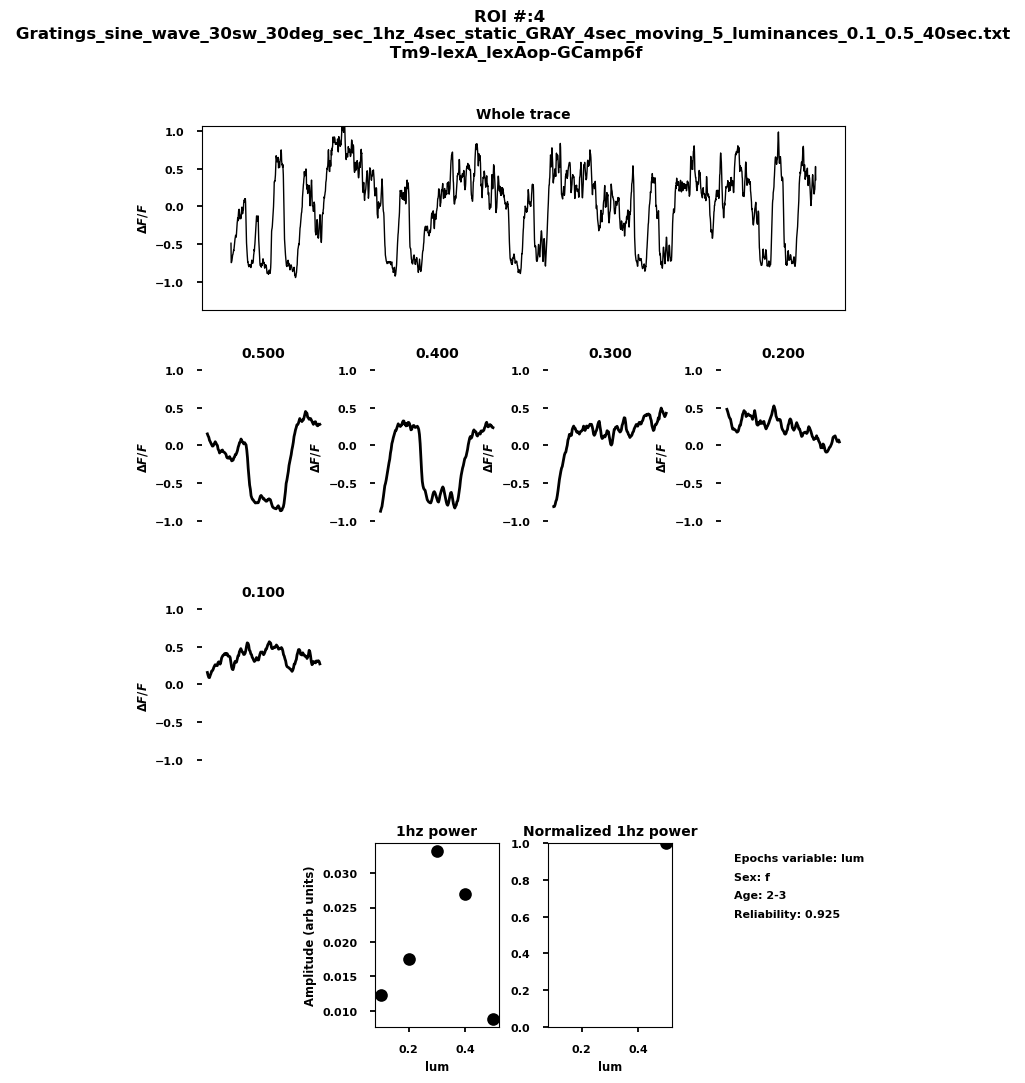

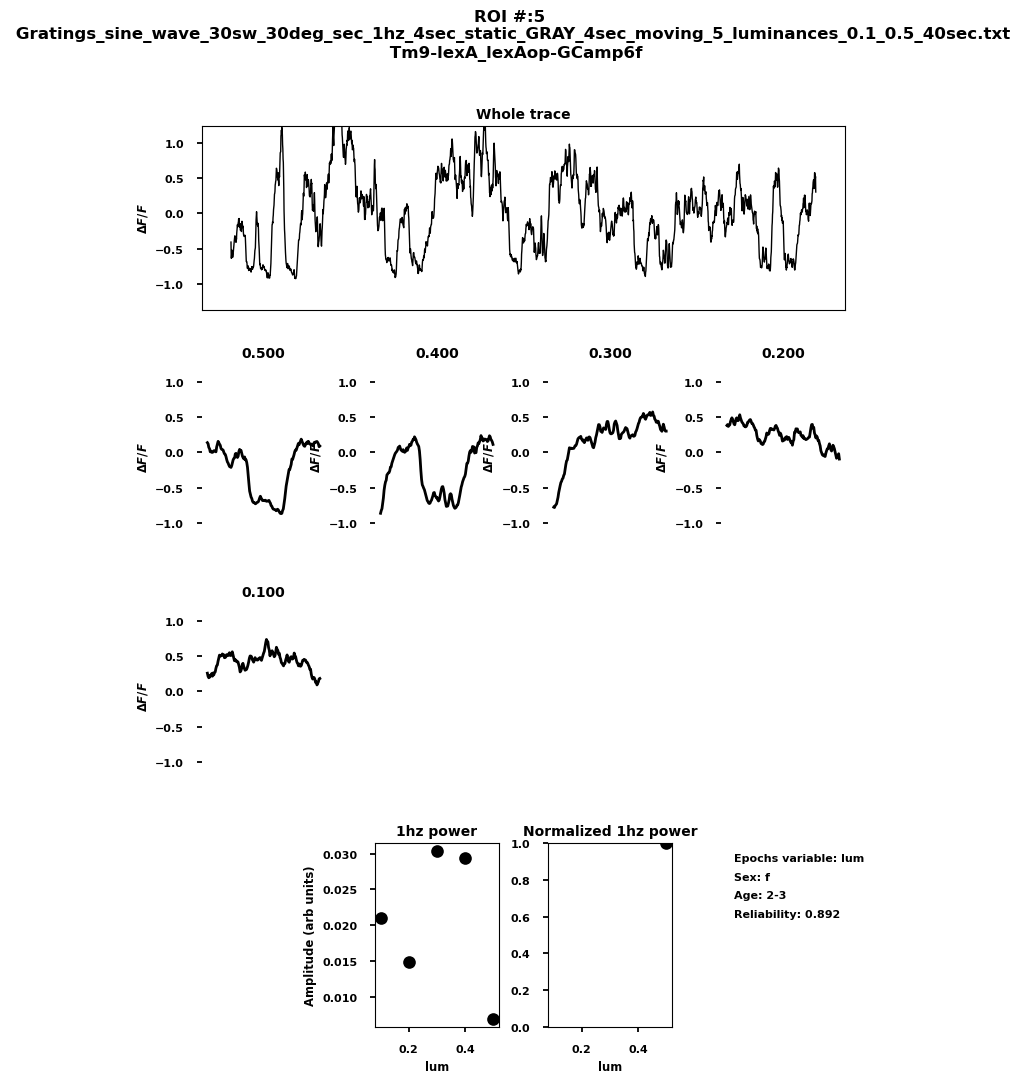

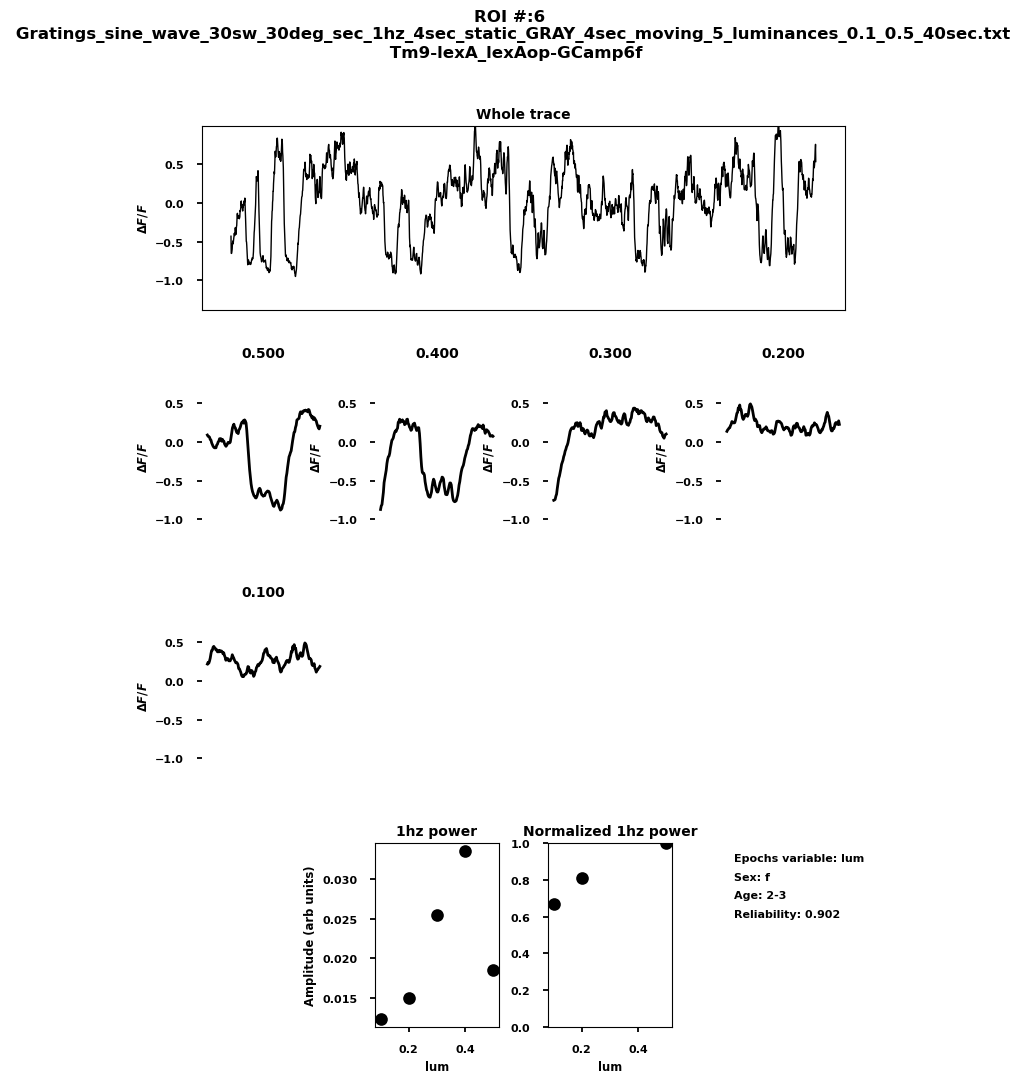

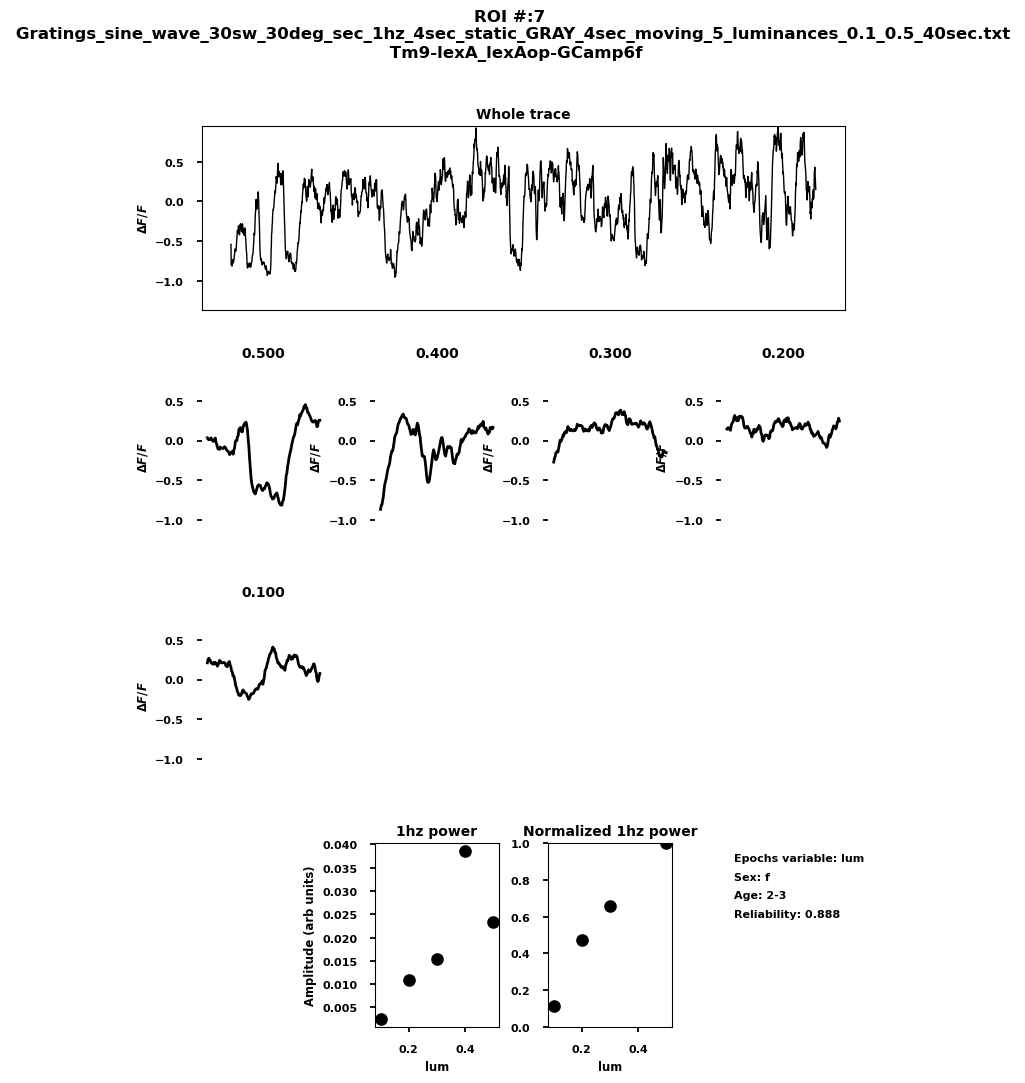

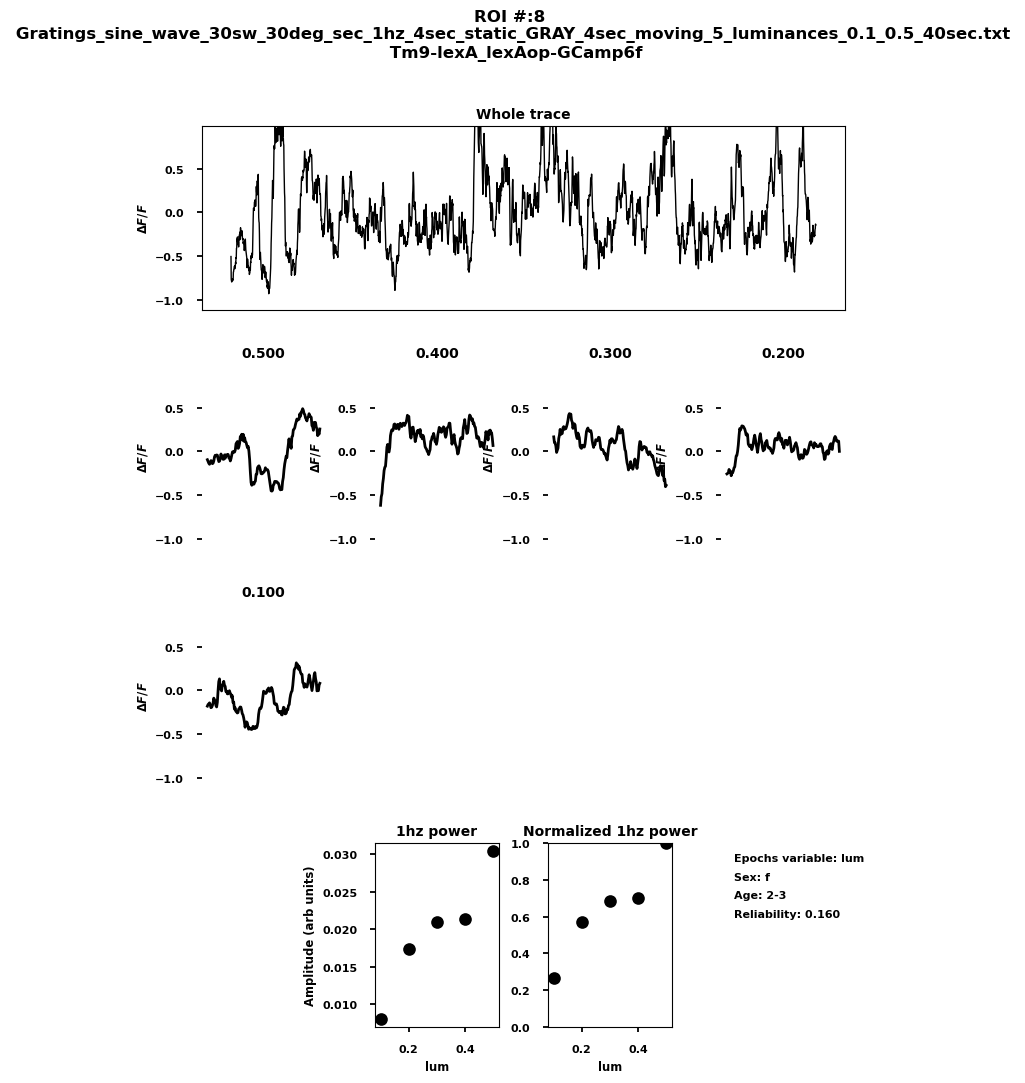

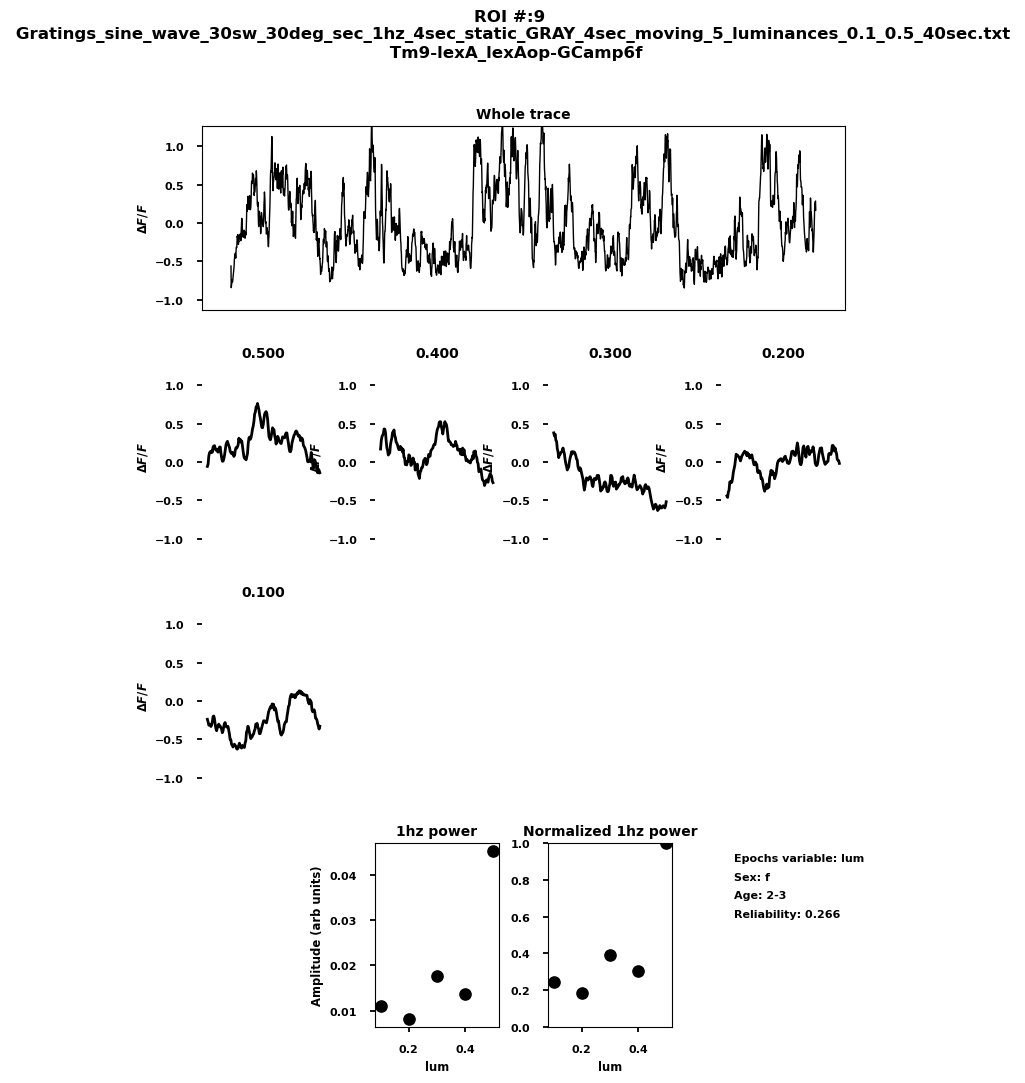

In [22]:
#%% Run desired analyses for different types
final_rois = pmc.run_analysis(analysis_params,final_rois,experiment_conditions,
                              imaging_information,summary_save_dir,
                              save_fig=True,fig_save_dir = figure_save_dir,
                              exp_ID=('%s_%s' % (current_movie_ID,
                                                 extraction_params['type'])))

ROI property images saved


C:\Users\jcornean\Anaconda3\envs\Msc_Course_2P\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jcornean\Anaconda3\envs\Msc_Course_2P\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\jcornean\Anaconda3\envs\Msc_Course_2P\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnin

ROI properties saved


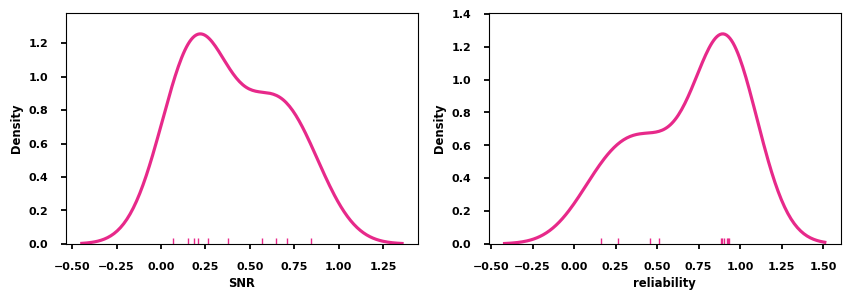

In [23]:
#%% Make figures for experiment summary and figure to show reliability and SNR plot
images = []
(properties, colormaps, vminmax, data_to_extract) = \
    pmc.select_properties_plot(final_rois , analysis_params['analysis_type'])
for prop in properties:
    images.append(ROI_mod.generate_colorMasks_properties(final_rois, prop))
pmc.plot_roi_properties(images, properties, colormaps, mean_image,
                        vminmax,current_movie_ID, imaging_information['depth'],
                        save_fig=True, save_dir=figure_save_dir,figsize=(8, 6),
                        alpha=0.5)
final_roi_data = ROI_mod.data_to_list(final_rois, data_to_extract)
rois_df = pd.DataFrame.from_dict(final_roi_data)

pmc.plot_df_dataset(rois_df,data_to_extract,
                    exp_ID=('%s_%s' % (current_movie_ID,
                                       extraction_params['type'])),
                    save_fig=True, save_dir=figure_save_dir)
#plt.close('all')

### 8. Save analysed data

Now the data is saved in a pickle file. Each ROI will be its own dictionary with all the generated data as keys and values inside. Every fly/ TSeries/ recording will have its own pickle file.

In [24]:
# Save data
saveOutputDir = os.path.join(initialDirectory, 'analyzed_data')
if save_data:
    os.chdir(dataFolder) # Seb: data_save_vars.txt file needs to be there    
    varDict = locals()
    pckl_save_name = ('%s_%s' % (current_movie_ID, extraction_params['type']))
    saveOutputDir = os.path.join(saveOutputDir, varDict['varDict']['stimulus_information']['stim_name'][:-4]) #Seb: experiment_folder/analyzed_data/stim_name/genotype_folder
    if not os.path.exists(saveOutputDir):
            os.mkdir(saveOutputDir) # Seb: creating stim_folder
    saveOutputDir = os.path.join(saveOutputDir,save_folder_geno)
    if not os.path.exists(saveOutputDir):
            os.mkdir(saveOutputDir) # Seb: creating genotype_folder
    saveWorkspace(saveOutputDir,pckl_save_name, varDict, 
               varFile='data_save_vars.txt',extension='.pickle')

    print('\n\n%s saved...\n\n' % pckl_save_name)
else:
    print('Pickle data not created')

data_save_vars.txt


2022_05_17_Tm9_fly2-TSeries-05172022_fly2-005_manual saved...




### 9. Ploting the data

In [25]:
print (f'Here is the saved pickle file:\n {saveOutputDir}\n')
data_dir = saveOutputDir
results_save_dir = os.path.join(saveOutputDir ,'results')
if not os.path.exists(results_save_dir):
    os.mkdir(results_save_dir)
    
print (f'And here we will save the plots that are generated in the last step:\n {results_save_dir}')

Here is the saved pickle file:
 C:\Users\jcornean\msc_course\Tm9\analyzed_data\Gratings_sine_wave_30sw_30deg_sec_1hz_4sec_static_GRAY_4sec_moving_5_luminances_0.1_0.5_40sec\Expline

And here we will save the plots that are generated in the last step:
 C:\Users\jcornean\msc_course\Tm9\analyzed_data\Gratings_sine_wave_30sw_30deg_sec_1hz_4sec_static_GRAY_4sec_moving_5_luminances_0.1_0.5_40sec\Expline\results


In [29]:
plot_only_cat = True
noisy_grating_analysis = False
stimulusFolder = 'Gratings_sine_wave_30sw_30deg_sec_1hz_4sec_static_GRAY_4sec_moving_5_luminances_0.1_0.5_40sec'

# Loading data and some parameters
polarity_dict, cat_dict = pag.get_polarity_and_cat_dict()
all_rois, combined_df, tunings, z_tunings, baselines, baseline_power, _variable = pag.load_pickle_data (data_dir, noisy_grating_analysis, stimulusFolder)
all_rois, combined_df, tunings, z_tunings, baselines, baseline_power = pag.concatinate_flies (all_rois, combined_df, tunings, z_tunings, baselines, baseline_power)


Tm9-lexA_lexAop-GCamp6f
Gratings_sine_wave_30sw_30deg_sec_1hz_4sec_static_GRAY_4sec_moving_5_luminances_0.1_0.5_40sec.txt
2022_05_17_Tm9_fly2-TSeries-05172022_fly2-005_manual.pickle successfully loaded



In [27]:
combined_df

,SNR,Reliab,depth,slope,RF_map_center,RF_map_bool,RF_distance_to_center,RF_horizontal_center,RF_vertical_center,base_slope,category,reliability,flyID,Geno,uniq_id,flyIDNum
0,0.570614,NaN,27.43,0.060344,None,False,NaN,NaN,NaN,-1.572067,NaN,0.931255,2022_05_17_Tm9_fly2,Tm9,1966155463648,0
1,0.845580,NaN,27.43,0.044566,None,False,NaN,NaN,NaN,-1.512540,NaN,0.923030,2022_05_17_Tm9_fly2,Tm9,1966155461680,0
2,0.378316,NaN,27.43,0.009862,None,False,NaN,NaN,NaN,-1.490988,NaN,0.925070,2022_05_17_Tm9_fly2,Tm9,1966155462016,0
3,0.183072,NaN,27.43,0.001618,None,False,NaN,NaN,NaN,-1.254760,NaN,0.891620,2022_05_17_Tm9_fly2,Tm9,1966155463552,0
4,0.706827,NaN,27.43,0.022826,None,False,NaN,NaN,NaN,-1.282175,NaN,0.902133,2022_05_17_Tm9_fly2,Tm9,1966155461776,0
5,0.645793,NaN,27.43,0.037111,None,False,NaN,NaN,NaN,-1.073596,NaN,0.887502,2022_05_17_Tm9_fly2,Tm9,1966155461584,0


In [30]:
# define color dict
_, colors = pac.run_matplotlib_params()
c_dict = {k:colors[k] for k in colors if k in combined_df['Geno'].unique()}

No pre-defined category for Tm9 found. Taking all...



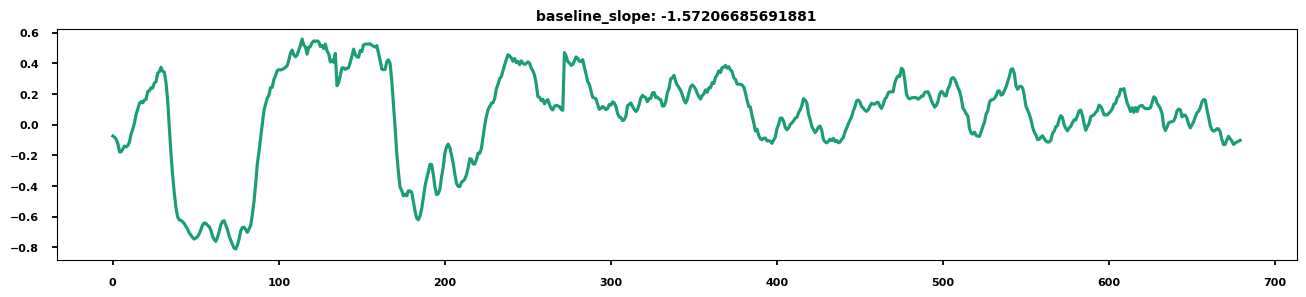

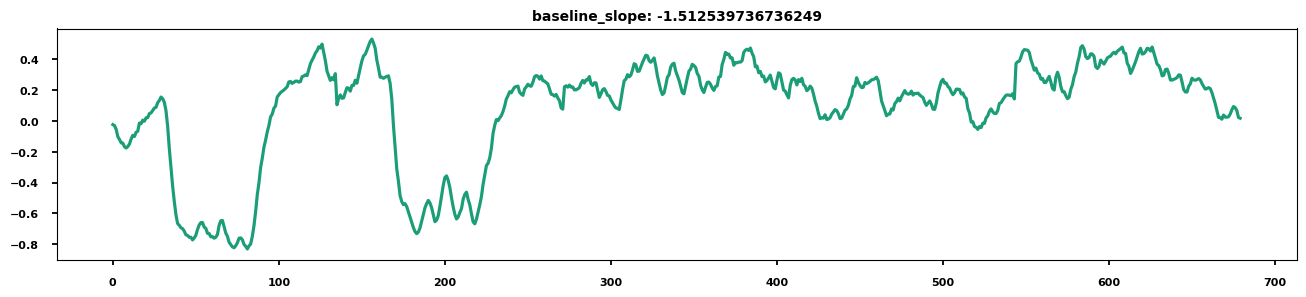

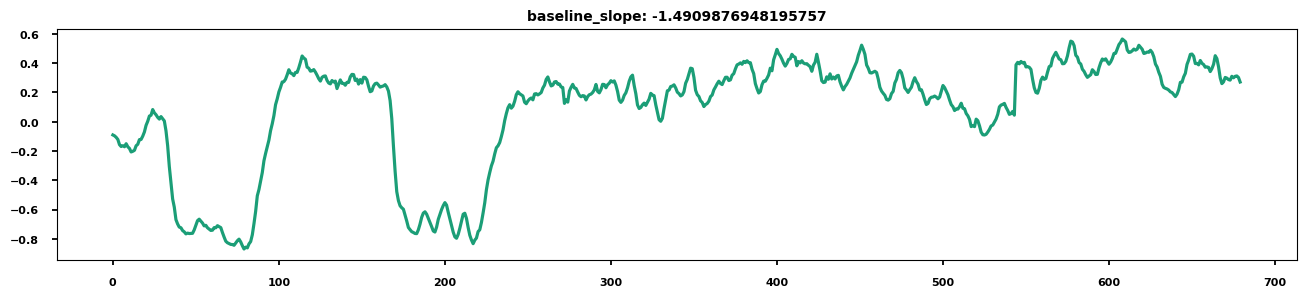

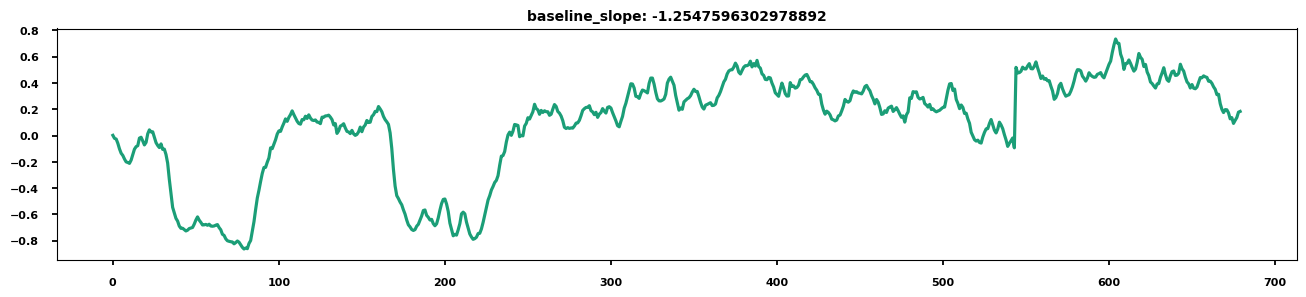

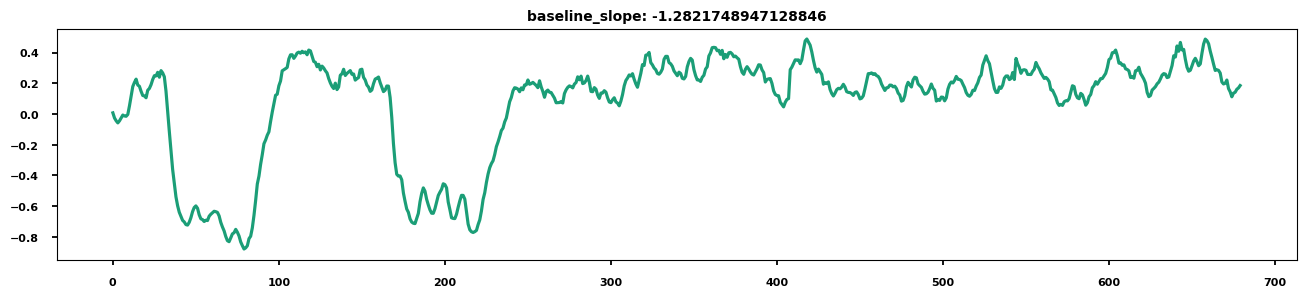

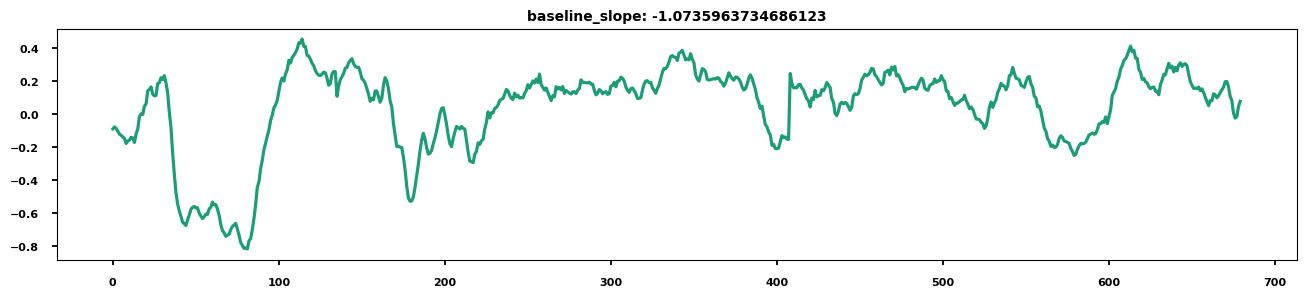

In [31]:
plt.close('all')
for idx, geno in enumerate(np.unique(combined_df['Geno'])):
   
    geno_color = c_dict[geno] #  colors[genotype_colors[0]]
    save_n = '{g}_raw'.format(g=geno)
    neuron_save_dir = os.path.join(results_save_dir,save_n) #directory where this plot is saved
    if not os.path.exists(neuron_save_dir): #if it does not exist jet, make a folder
        os.mkdir(neuron_save_dir)
    
    curr_neuron_mask = pag.plot_only_cat_params(plot_only_cat, cat_dict, combined_df, geno, polarity_dict)
    
    curr_rois = all_rois[curr_neuron_mask]
    for idx, roi in enumerate(curr_rois):
        
        fig = plt.figure(figsize=(16, 3))
        plt.plot(roi.conc_resp,color = geno_color)
        save_name = '{geno}_ROI_{n}'.format(geno=geno,n=idx)
        plt.title('baseline_slope: {bs}'.format(bs=roi.base_slope))
        os.chdir(neuron_save_dir)
        plt.savefig('%s.png' % save_name, bbox_inches='tight')
        plt.savefig('%s.pdf' % save_name, bbox_inches='tight')
        #plt.close('all')

Please plot different parameters of the data, e.g:
- df_trace
- raw_trace

What do you see when you compare these two traces?

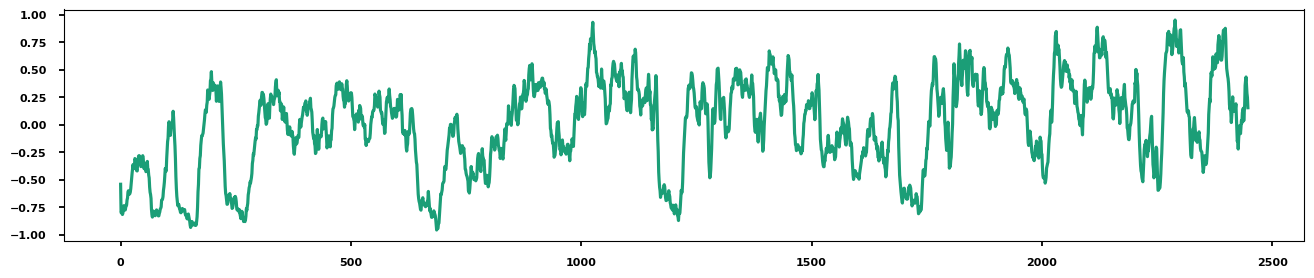

In [32]:
fig = plt.figure(figsize=(16, 3))
plt.plot(roi.df_trace,color = geno_color)

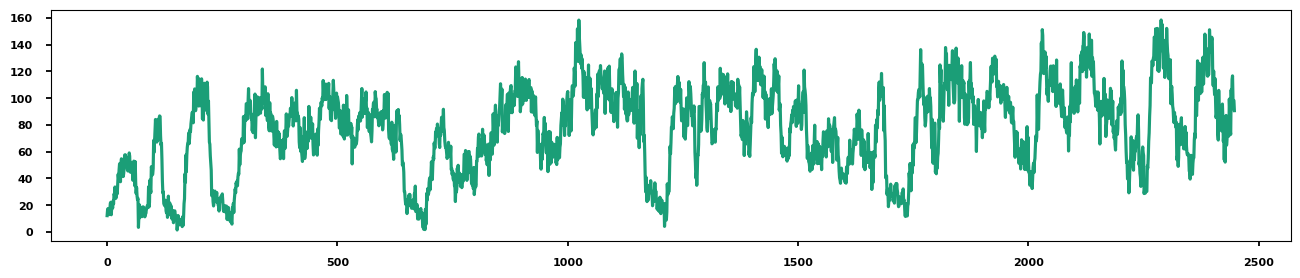

In [33]:
fig = plt.figure(figsize=(16, 3))
plt.plot(roi.raw_trace,color = geno_color)

In [34]:
# writing a function

def calculate_data_to_plot (plot_only_cat, cat_dict, combined_df, geno, polarity_dict, all_rois, tuning_c, mean_type):
    curr_neuron_mask = pag.plot_only_cat_params(plot_only_cat, cat_dict, combined_df, geno, polarity_dict)
    curr_df = combined_df[curr_neuron_mask]

    diff_luminances = all_rois[curr_neuron_mask][0].luminances
    sensitivities = tunings[curr_neuron_mask]
    properties = ['Luminance', 'Response']
    senst_df = pd.DataFrame(columns=properties)
    
    tuning_curves = tuning_c[curr_neuron_mask]
    
    a=pac.compute_over_samples_groups(data = tuning_curves, 
                                group_ids= np.array(combined_df[curr_neuron_mask]['flyIDNum']), 
                                error ='SEM',
                                experiment_ids = np.array(combined_df[curr_neuron_mask]['Geno']))

    label = '{g} n: {f}({ROI})'.format(g=geno,
                                       f=len(a['experiment_ids'][geno]['over_samples_means']),
                                       ROI=len(a['experiment_ids'][geno]['all_samples']))
    
    if mean_type == 'groups':        
        all_mean_data = a['experiment_ids'][geno]['over_groups_mean']
        print(geno,all_mean_data)
        all_yerr = a['experiment_ids'][geno]['over_groups_error']
    elif mean_type == 'samples':
        mean_flies = np.array(a['experiment_ids'][geno]['over_samples_means'])
        #mean_flies= mean_flies/mean_flies.max(1).reshape(mean_flies.shape[0],1) # For normalization, uncomment
        all_mean_data = mean_flies.mean(0)
        all_yerr = mean_flies.std(0)/np.sqrt(mean_flies.shape[0])
    
    return (all_mean_data, all_yerr, diff_luminances, label)

No pre-defined category for Tm9 found. Taking all...

Tm9 [0.01241519 0.03161718 0.01827607 0.00855637 0.00925163]


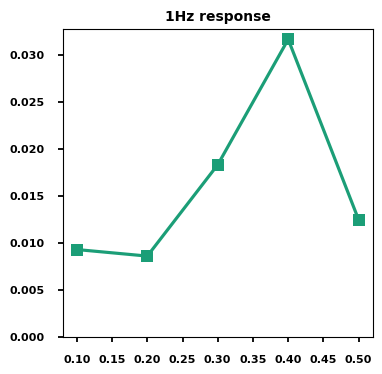

In [35]:
#Plotting 1 Hz response

for idx, geno in enumerate(np.unique(combined_df['Geno'])):
    geno_color = c_dict[geno] #  colors[genotype_colors[0]]
    neuron_save_dir = os.path.join(results_save_dir,'sine1Hz')
    if not os.path.exists(neuron_save_dir):
        os.mkdir(neuron_save_dir)
        
    all_mean_data, all_yerr, diff_luminances, label = calculate_data_to_plot (plot_only_cat, cat_dict, combined_df, geno, polarity_dict, all_rois,tuning_c=tunings, mean_type='groups')
    
    fig = plt.figure(figsize=(4, 4))
    grid = plt.GridSpec(1, 1, wspace=0.3, hspace=1)
    ax1=plt.subplot(grid[0,0])
    ax1.errorbar(diff_luminances,all_mean_data,all_yerr,
                 fmt='-s',alpha=1,color=geno_color,label=label)
    ax1.set_ylim((0,ax1.get_ylim()[1]))
    ax1.set_title('1Hz response')

No pre-defined category for Tm9 found. Taking all...

Tm9 [0.01241519 0.03161718 0.01827607 0.00855637 0.00925163]
No pre-defined category for Tm9 found. Taking all...

Tm9 [-0.44863901 -0.37515348  0.00452703  0.03129781  0.03031244]


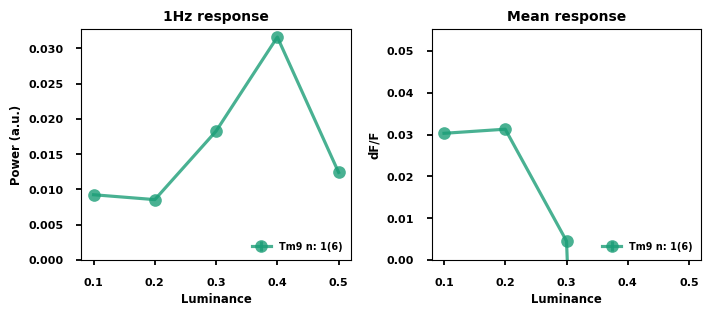

In [36]:
fig = plt.figure(figsize=(8, 3))
grid = plt.GridSpec(1,2, wspace=0.3, hspace=1)

ax1=plt.subplot(grid[0,0])
ax2=plt.subplot(grid[0,1])

for idx, geno in enumerate(np.unique(combined_df['Geno'])):
    geno_color = c_dict[geno] # colors[genotype_colors[idx]] 
    
    all_mean_data, all_yerr, diff_luminances, label = calculate_data_to_plot (plot_only_cat, cat_dict, combined_df, geno, polarity_dict, all_rois,tuning_c=tunings, mean_type='groups')
    
    ax1.errorbar(diff_luminances,all_mean_data,all_yerr,
                 fmt='-o',alpha=.8,color=geno_color,label=label)
    
    
    # AX2
    all_mean_data, all_yerr, diff_luminances, label = calculate_data_to_plot (plot_only_cat, cat_dict, combined_df, geno, polarity_dict, all_rois,tuning_c=baselines, mean_type='groups')

    ax2.errorbar(diff_luminances,all_mean_data,all_yerr,
                 fmt='-o',alpha=.8,color=geno_color,label=label)
    
ax1.set_ylim((0,ax1.get_ylim()[1]))
ax1.set_title('1Hz response')
ax1.legend(loc=4)
ax1.set_ylabel('Power (a.u.)')
ax1.set_xlabel(_variable)

ax2.set_ylim((0,ax2.get_ylim()[1]))
ax2.set_title('Mean response')
ax2.legend(loc=4)
ax2.set_ylabel('dF/F')
ax2.set_xlabel(_variable)


save_name = 'Summary_1hz_mean_resp'.format(geno=geno)
os.chdir(neuron_save_dir)
plt.savefig('%s.pdf' % save_name, bbox_inches='tight',dpi=300) 
plt.show()

No pre-defined category for Tm9 found. Taking all...



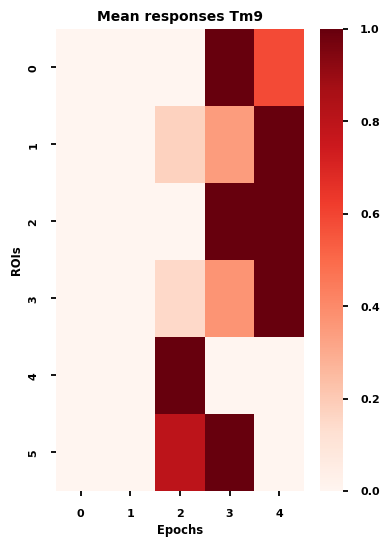

In [37]:
#Heat plots for mean response
for idx, geno in enumerate(np.unique(combined_df['Geno'])):
    if not(geno[:3] in ['L2_','L3_','Tm9','Tm1','Mi1']):
        continue
    
    curr_neuron_mask = pag.plot_only_cat_params(plot_only_cat, cat_dict, combined_df, geno, polarity_dict)
    curr_df = combined_df[curr_neuron_mask]
    
    mean_baselines = baselines[curr_neuron_mask]
    
    fig = plt.figure(figsize=(4, 6))
    # Baseline tunings
    plot_sens = (mean_baselines/mean_baselines.max(axis=1).reshape(mean_baselines.shape[0],1))
    sns.heatmap(plot_sens,cmap='Reds',vmin=0,vmax=1)
    plt.title('Mean responses {g}'.format(g=geno))
    plt.ylabel('ROIs')
    plt.xlabel('Epochs')
    
save_name = 'Heat_map_mean_response_Tm9'.format(geno=geno)
os.chdir(neuron_save_dir)
plt.savefig('%s.pdf' % save_name, bbox_inches='tight',dpi=300) 

In [128]:
print (curr_neuron_mask)

0    True
1    True
2    True
3    True
4    True
5    True
6    True
7    True
8    True
Name: Geno, dtype: bool
